In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from glob import glob
from re import compile
import re
from collections import defaultdict, OrderedDict, Counter
from itertools import chain, combinations
import operator
from operator import itemgetter
import os
import random
from tqdm import tqdm

In [2]:
os.chdir(r"C:\Users\HP\Python\LC_ByR")

In [3]:
np.random.seed(2022)

# Funcion de tokenizacion

In [4]:
regex = compile('[_{}—();\.,+:!\[0-9\]$\*"&#\/¡!¿?·''`“”‘]')               
    
def tokenize(text):
    """
    Función de tokenización.
    
    Arguments
    ---------
    text : str
        Cadena de texto que se tokenizará
        
    Returns
    -------
    tokens : list
        Lista de tokens
    """

    
    #Retiramos signos
    text= regex.sub(' ',text.lower())
    tok = text.split(' ')
    
    #Pasamos los tokens limpios a la lista tokens
    tokens = []
    for t in tok:
        #Retiramos ' al principio y al final de las string
        #No retiramos todas las ' pues hay palabras que no se entienderian sin '
        if "'" in t:
            a = re.sub("^'",'',t)
            a = re.sub("'$",'',a)
            tokens.append(a)
        #Retiramos las string vacias, pues nuestro corpus las genera por su estructura
        elif t == '':
            pass
        else:
            tokens.append(t)
    #Tomamos nuestros socumentos como oraciones completas y definimos donde empiezan y donde acaban
    tokens = ['<BOS>']+tokens+['<EOS>']
    
    return np.array(tokens)


# Obtener datos de entrenamiento y test, tokenizados

In [5]:
def data_train_test(corpus, porc = 0.8):
    """
    Función de tokenización.
    
    Arguments
    ---------
    Corpus : pd.DataFrame
        Dataframe con el titulo (title) y el texto (text)
    porc : float
        procetaje del corpus que se usara para el entrenamiento
        
    Returns
    -------
    tok_train0 : list
        Lista de tokens de entrenamiento
    tok_test0 : list
        Lista de tokens de prueba
    voc : list
        Lista de vocabulario de entrenamiento
    """
    
    #Indices para datos de entrenamiento y de prueba
    idx_train = np.sort(np.random.choice(np.array(range(corpus.shape[0])),int(corpus.shape[0]*porc),replace=False))
    idx_test = np.sort(np.array([i for i in range(corpus.shape[0]) if i not in idx_train]))
    
    #Datos de entrenamiento y de prueba
    data_train = data.loc[idx_train]
    data_test = data.loc[idx_test]
    
    #Dividimos en oraciones
    trn = [re.sub("\. ","    ",i) for i in data_train.text]
    tst = [re.sub("\. ","    ",i) for i in data_test.text]
    
    data_trn = list(chain(*[i.split("    ") for i in trn]))
    data_tst = list(chain(*[i.split("    ") for i in tst]))
    
    #Datos de entrenamiento y de prueba tokenizados
    tok_train = [list(tokenize(text)) for text in data_trn if list(tokenize(text)) != ['<BOS>','<EOS>']]
    tok_test = [list(tokenize(text)) for text in data_tst  if list(tokenize(text)) != ['<BOS>','<EOS>']]
    
    tok_train1 = [i for i in tok_train if i != ['<BOS>','<EOS>']]
    tok_test1 = [i for i in tok_test if i != ['<BOS>','<EOS>']]
    
    tok_train = list(chain(*tok_train1))
    tok_test = list(chain(*tok_test1))
    
    #Retiramos palabras de longitud 1 que puedan generar ruido
    
    tok_train0 = [i for i in tok_train if i in ['a','i'] or len(i)>1]
    tok_test0 = [i for i in tok_test if i in ['a','i'] or len(i)>1]
    
    # Vocabulario de entrenamiento
    voc = list(set(tok_train0))
    
    return np.array(tok_train0), np.array(tok_test0), np.array(voc)

# Funcion para n-gramas

In [6]:
def ngram(text, n = 3):
    """
    Función de tokenización.
    
    Arguments
    ---------
    text : list
        Lista con texto tokenizado y ordenado
    n : int
        Entero para definir el tamaño de los n-gramas
        
    Returns
    -------
    inputs : list
        n-1 grama
    targets : list
        Palabra inmediata al n-1 grama, en el texto original
    """
    
    
    
    #Creamos las listas inputs y targets
    inputs = []
    targets = []
    for idx in range(len(text)-n+1):
        inp = []
        for i in range(idx,idx+n-1):
            inp.append(text[i])
        inputs.append(inp)
        targets.append([text[idx+n-1]])
        
        
    return np.array(inputs), np.array(targets)

# Datos

In [7]:
data = pd.read_csv(r"Poe.csv")

In [8]:
#Tomamos solo 30 textos, pues el entrenamiento el tardado, y el curpus amplio
data = data[['title','text']].loc[list(range(15))]

In [9]:
data_train, data_test, voc = data_train_test(data)

In [10]:
data_train, data_test, voc

(array(['<BOS>', 'what', 'chance', ..., 'lyttleton', 'barry', '<EOS>'],
       dtype='<U22'),
 array(['<BOS>', 'the', 'ways', ..., 'at', 'all', '<EOS>'], dtype='<U20'),
 array(['shine', 'laws', 'respiratory', ..., 'smoother', 'portal',
        'swooned'], dtype='<U22'))

In [11]:
#Indice por palabra
ind_w = {word : idx for idx, word in enumerate(voc)}

In [12]:
#Transcribiendo palabras con sus indices
data_train_n = [ind_w[word] for word in data_train]

In [13]:
#N-gramas
#valor de entrada y valor esperado
inp_ng , tar_ng = ngram(data_train_n,2)

In [14]:
len(inp_ng)

46708

# Definiendo capas

In [15]:
#Dimensiones solicitadas
dim1 = 128
dim2 = 254


#Dividimos nuestras capas ya que nos devuelven valores muy altos

#capa de embedding
emb = np.random.randn(dim1, len(voc)) / np.sqrt(len(voc))
#Capa de oculta
oc = np.random.randn(dim2,dim1) / np.sqrt(len(voc))
b = np.zeros((1,dim2))
#Capa de salida
ou = np.random.randn(len(voc),dim2) / np.sqrt(len(voc))
c = np.zeros((1, len(voc)))

## Entrenamiento

In [16]:
#Tomamos un iteracion al ser tan grande el corpus
iteraciones = 2
#tasa de apendizaje
lr = 0.1


for i in range(iteraciones):

    for idx, ex in tqdm(enumerate(inp_ng)):
        #FORWARD
        #Capa de embedding
        em = np.squeeze(emb.T[ex])
        #Capa oculta
        a = np.squeeze(np.tanh(np.dot(oc,em)+b))
        #Capa salida
        d =  np.squeeze(np.exp(np.dot(ou,a)+c))
        #Softmax
        out = np.exp(d - np.max(d))
        f = out/out.sum(0)
        

        #BACKPROP
        #Derivadas
        d_out = f
        d_out[tar_ng[idx]] -= 1
        
        d_tanh = (1-a**2)*np.dot(ou.T,d_out)
        
        d_emb = np.dot(oc.T,d_tanh)
        
        #Actualizaciones
        ou -= lr*np.outer(d_out,a)
        
        c -= lr*d_out
        
        oc -= lr*np.outer(d_tanh,em)
        
        b -= lr*d_tanh
        
        emb.T[ex] -= lr*d_emb  

46708it [20:26, 38.07it/s]
46708it [23:39, 32.90it/s]


In [17]:
ww = emb.T[ind_w['<BOS>']]

In [18]:
def forward(x):    
    """Evalua palabras en el modelo"""
    
    if x in voc:
        em = emb.T[ind_w[x]]
        a = np.squeeze(np.tanh(np.dot(oc,em) + b))
        out = np.squeeze(np.exp(np.dot(ou,a) + c))
        p = out/out.sum(0)
    else:
        return np.ones(len(voc))
    return p

In [66]:
forward('<BOS>')

array([1.11387476e-04, 1.04733005e-04, 8.12580239e-05, ...,
       1.17439687e-04, 1.04997009e-04, 1.24213145e-04])

In [73]:
#probabilidad de la cadena 'that is'
forward('that')[ind_w['is']]

0.0008409454070789586

In [20]:
def nxt_max(val):
    """Calcula la palabra mas probable siguiente"""
    if val not in ind_w.keys():
        return "word doesn't exist in the vocabulary"
    prob = forward(val)
    # return prob
    # return list(np.where(prob==np.max(prob)))[0]
    idx = np.argmax(prob)
    
    return list(ind_w.keys())[idx]

In [74]:
#Palabra mas probable despues de 'this'
nxt_max('this')

'means'

# Perplejidad/Entropia

In [75]:
def prob(o):
    """Probabilidad de una oracion"""
    o = o.split(' ')
    b_g = list(zip(o,o[1:]))
    prb = 1
    
    # probabilididad si se empieza con un caracter distinto de '<BOS>'
    if o[0] in voc and o[0]!='<BOS>':
        prb *= forward(ind_w['<BOS>'])[ind_w[o[0]]]
    
    # Probabilidad de la oracion en razon de los bigramas
    for i in b_g:
        if i[0] in voc and i[1] in voc:
            prb = prb*forward(i[0])[ind_w[o[1]]]
        else:
            pass
    return prb

## Oraciones para test

In [23]:
# Reescribiendo oraciones de manera adecuada para evaluacion
oraciones_tst = []
orac = []
for i in data_test:
    orac.append(i)
    if i == '<EOS>':
        oraciones_tst.append(' '.join(orac))
        orac = []

In [67]:
oraciones_tst

['<BOS> the ways of god in nature as in providence are not as our ways nor are the models that we frame any way commensurate to the vastness profundity and unsearchableness of his works which have a depth in them greater than the well of democritus <EOS>',
 '<BOS> joseph glanville <EOS>',
 '<BOS> we had now reached the summit of the loftiest crag <EOS>',
 '<BOS> for some minutes the old man seemed too much exhausted to speak <EOS>',
 '<BOS> not long ago said he at length and i could have guided you on this route as well as the youngest of my sons but about three years past there happened to me an event such as never happened to mortal man or at least such as no man ever survived to tell of and the six hours of deadly terror which i then endured have broken me up body and soul <EOS>',
 '<BOS> you suppose me a very old man but i am not <EOS>',
 '<BOS> it took less than a single day to change these hairs from a jetty black to white to weaken my limbs and to unstring my nerves so that i tr

In [53]:
#Evaluación del modelo
pb = []
for orc in oraciones_tst:
    try:
        prob_o = prob(orc)
        pb.append(prob_o)
    except:
        pass

In [72]:
#Removemos los ceros, que resultan cuando los valores son tan cercanos a cero
pb0 = [i for i in pb if i != 0]

In [58]:
#Entropia
H = 0
for i in pb0:
    H-= i*np.log2(i)

In [59]:
print(f'Entropia: {H}')
print(f'Perplejidad: {2**H}')

Entropia: 0.012628991853043241
Perplejidad: 1.0087921762089813


Proyectamos solo una cantidad limitada de palbras para no saturar el plot, pues el vocabulario es amplio

Para el plot tome el codigo que se ha presentado en clase en los notebooks, para imprimir las palabras

In [71]:
def plot_words(Z,ids):
    Z = PCA(2).fit_transform(Z)
    r=0
    plt.figure(figsize=(20, 20))
    plt.scatter(Z[:,0],Z[:,1], marker='o', c='blue')
    for label,x,y in zip(ids, Z[:,0], Z[:,1]):
        plt.annotate(label, xy=(x,y), xytext=(-1,1), textcoords='offset points', ha='center', va='bottom')
        r+=1
    plt.show()

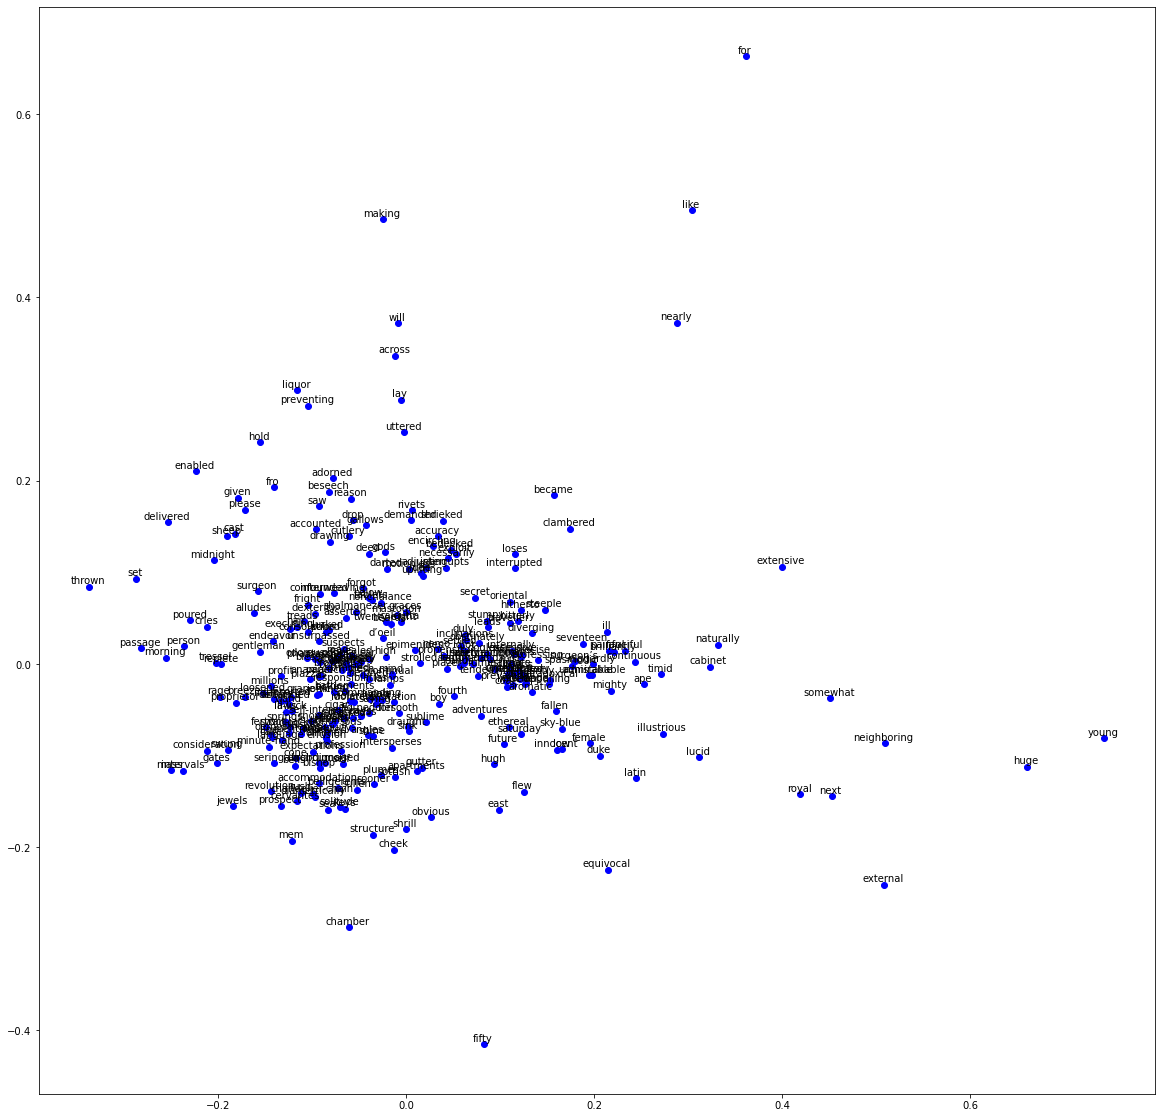

In [77]:
label = [w[0] for w in sorted(ind_w.items(), key=itemgetter(1))]
plot_words(emb.T[:300],label[:300])

### Guardando palabras deapues del embedding

In [61]:
np.save('dict_words_ind.npy', ind_w)

In [62]:
embed_w = {i:emb.T[i] for i in range(len(voc))}

In [63]:
np.save('dict_emb.npy', embed_w)